<a href="https://colab.research.google.com/github/sunhuanhuan920/ECE1512_2023F_ProjectRepo_Zhenhuan_Sun/blob/main/Project%20A/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2: Knowledge Distillation in MHIST Dataset**

# Question 1

(a). MHIST dataset contains images of colorectal polyps. Both pre-trained ResNet50 and pre-trained MobileNetV2 do not possess the capability to classify colorectal polyps, as ImageNet does not contain any colorectal polyps examples. However, the first few layers of DNN, especially those trained on ImageNet, can usually capture general features in images like edges, textures, and shapes. These features are often generic and can be beneficial for many other visual classification tasks. By using the architecture of ResNet50 or MobileNetV2 and their trained weights, we can leverage their already-learned primitive features identifiers for our tasks. In addition, the final layer of DNNs is usually customized for the dataset they are trained on. For example, different dataset may contain different number of classes, and thus having different number of neurons in their last layers. By leveraging fine-tuning processes, even though the MHIST dataset have different classes than ImageNet, we can replace the output layer of ResNet50 and MobileNetV2 with custom layers tailored for MHIST, then freeze the per-trained layers and fine-tunes the parameters on those custom layers based on the MHIST dataset.

(b). Residual block is a fundamental unit in Residual Network architecutres. It usually contains 2 convolutional layers with batch normalization layer attached after each, activation functions, and most importantly a residual path that connect the input of block to the output, creating skip connection.

(c). Compared to ResNetV1 which has the following order within the residual block: Conv -> BN -> ReLU, the order within the residual block has changed to: BN -> ReLU -> Conv in ResNetV2. In addtion, in ResNetV1, ReLU activation is applied after the addition of the residual path. In ResNetV2, no activation is applied after addition.

(d). MobileNetV1 used depthwise separable convolutions to reduce computational cost and build lightweight DNNs. MobileNetV2 build upon this by adding linear bottlenecks between the layers and connecting bottlenecks with residual path, which forms an inverted residual block.

(e). This is due to the presence of residual connection in the residual block. For example, we can express the function in residual block as $f(x) + x$, where $f(x)$ is the function performed by the original layers and $+ x$ is the residual connection in the block. If we take the derivative of $f(x) + x$ with respect to $x$, we will get $\frac{d}{dx} f(x) + 1$. The vanishing gradient problem is usually occured during backpropogation where gredients are repeatedly multiplied by some small number during the backpropogation along the $f(x)$ path, i.e., $\frac{d}{dx} f(x)$. The $+ 1$ gives the backpropogated gradient a path to avoid the processing done in $f(x)$ and flow uninterruptly, which essentially mitigate the problem of vanishing gradient.

(f). MobileNetV2 is considered as a lightweight model. It and its predecessor MobileNetV1 are designed for mobile devices with limited computation resources. Thus, its architecture, such as depthwise separable convolutions and inverted residual blocks, are tailored to reduce the number of FLOPs and parameters required to make prediction and provide a good balance between performance and computational efficiency.

# Question 2

**Load dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Project_A_Supp/mhist_dataset

!unzip images.zip

In [28]:
import pandas as pd

annotations = pd.read_csv('annotations.csv')
annotations.head(10)

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train
5,MHIST_aag.png,HP,2,test
6,MHIST_aah.png,HP,2,test
7,MHIST_aai.png,HP,3,train
8,MHIST_aaj.png,HP,0,train
9,MHIST_aak.png,HP,2,train


In [26]:
train_annotations = annotations[annotations['Partition'] == 'train']
train_annotations.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


In [27]:
test_annotations = annotations[annotations['Partition'] == 'test']
test_annotations.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
5,MHIST_aag.png,HP,2,test
6,MHIST_aah.png,HP,2,test
14,MHIST_aaq.png,SSA,5,test
15,MHIST_aar.png,HP,0,test
22,MHIST_aay.png,HP,1,test


In [47]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MHISTDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')

        label = self.annotations.iloc[index, 1]
        # 0 for SSA, 1 for HP
        label = 0 if label == "SSA" else 1

        if self.transform:
            image = self.transform(image)

        return image, label

In [53]:
# Load the training dataset without any normalization
train_dataset_raw = MHISTDataset(annotations=train_annotations, img_dir='./images/', transform=transforms.ToTensor())

# Compute the mean and std
means = torch.zeros(3)
stds = torch.zeros(3)
for img, _ in train_dataset_raw:
    means += torch.mean(img, dim=(1,2))
    stds += torch.std(img, dim=(1,2))

means /= len(train_dataset_raw)
stds /= len(train_dataset_raw)

# Define plain transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# Define training data transformation with computed mean and std values
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

# define test data transformation with computed mean and std values
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

train_dataset = MHISTDataset(annotations=train_annotations, img_dir='./images/', transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MHISTDataset(annotations=test_annotations, img_dir='./images/', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
print("Number of samples in training set:", len(train_dataset))
print("Number of samples in test set:", len(test_dataset))

# Fetch a single sample (image and label) from the training dataset
image, label = train_dataset[0]
# Each image has shape: [channels, height, width]
print("Shape of the image:", image.shape)

Number of samples in training set: 2175
Number of samples in test set: 977
Shape of the image: torch.Size([3, 224, 224])


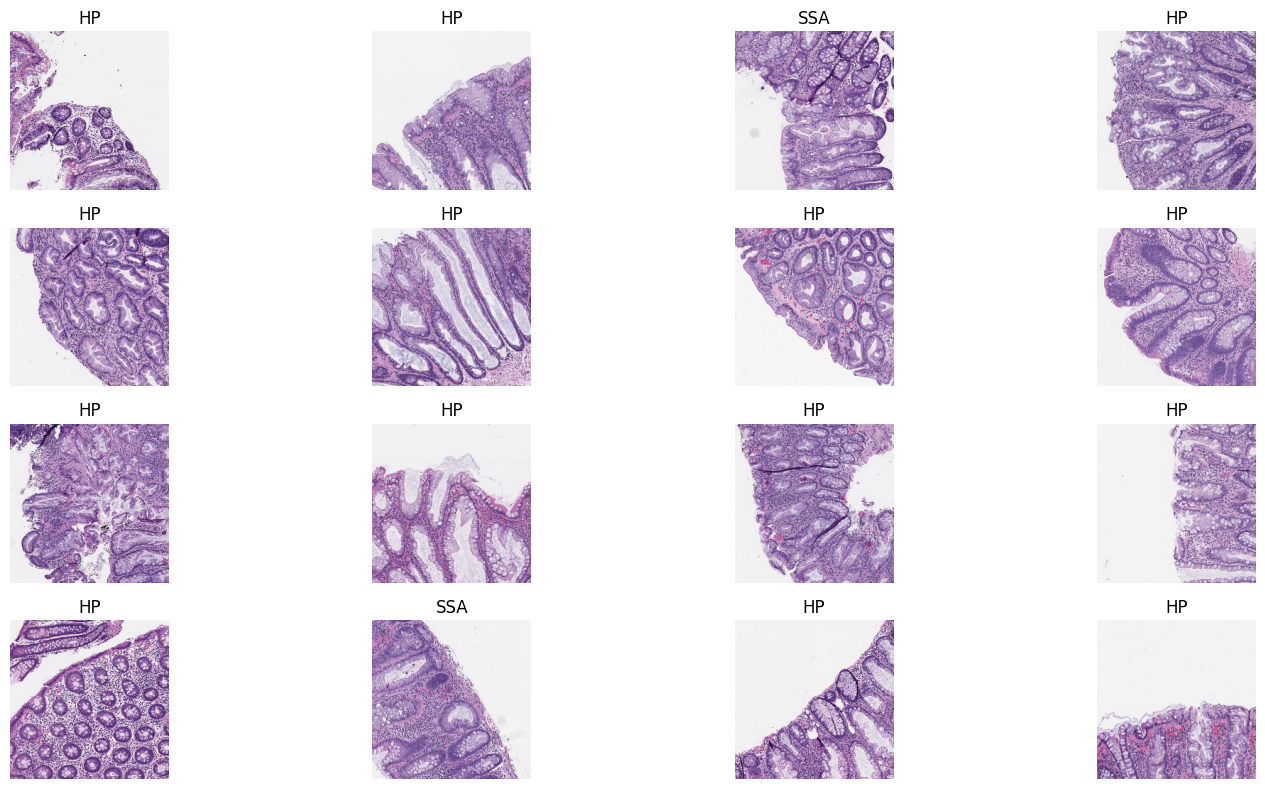

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to unnormalize and display an image
def imshow(ax, img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    # Unnormalize the image
    img = stds * img + means
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1 to display correctly
    ax.imshow(img)
    ax.axis('off')

# Get a batch of images and labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Convert labels back to their string representation for visualization
label_map = {0: "SSA", 1: "HP"}
labels = [label_map[int(i)] for i in labels]

# Display images with labels
fig = plt.figure(figsize=(16, 8))
for idx in np.arange(16):  # Displaying first 16 images of the batch
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    imshow(ax, images[idx])
    ax.set_title(labels[idx])
plt.tight_layout()
plt.show()

**Model creation**